In [1]:
from bioio import BioImage
from matplotlib import pyplot as plt
import numpy as np
import skimage
from scipy import stats, ndimage
import math
import csv
import random
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [3]:
# Path to image
image_file = ("..\\data\\Day 1 adult animals\\D1A_rep 3.nd2")

# Create a BioImage reader
reader = BioImage(image_file)

# Get number of z-planes
size_z = reader.shape[2]

image = reader.get_image_data("YXC", Z=2)


In [4]:
sam2_checkpoint = "inc/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

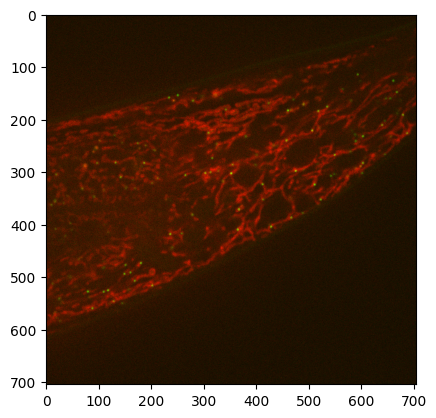

In [5]:
# Preprocess the image - SAM2 expects RGB images in the range [0 1]

image_processed = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
for z in range(image.shape[2]):
    curr_slice = image[:, :, z].astype(np.float32)
    curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
    image_processed[:, :, z] = curr_slice

plt.imshow(image_processed)

In [6]:
predictor.set_image(image_processed)

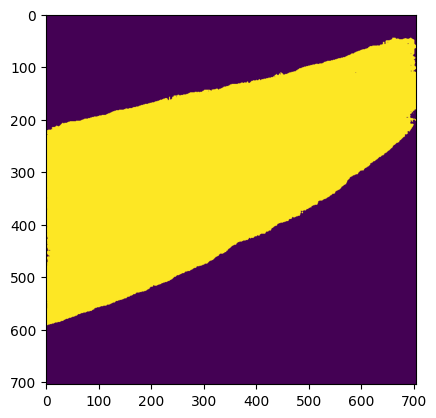

In [7]:
bbox = np.array([0, 0, 700, 600])  #[left, top, right, bottom]

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox,
    multimask_output=True,
)

plt.imshow(masks[0, :, :])




In [8]:
print(scores)

[0.9083076  0.9223345  0.93714666]


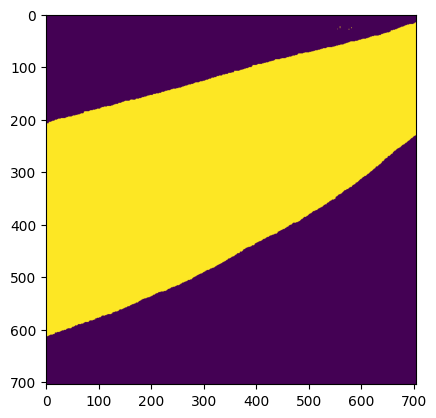

In [18]:
# Or is it better to just use the green channel?

image_processed = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
curr_slice = image[:, :, 1].astype(np.float32)
curr_slice = skimage.filters.gaussian(curr_slice, 1)

curr_slice = (curr_slice - np.min(curr_slice))/(np.max(curr_slice) - np.min(curr_slice))
#curr_slice = skimage.exposure.adjust_sigmoid(curr_slice)

image_processed[:, :, 1] = curr_slice

predictor.set_image(image_processed)

bbox = np.array([0, 0, 700, 600])  #[left, top, right, bottom]

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox,
    multimask_output=True,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

best_mask = masks[:, :, 0]


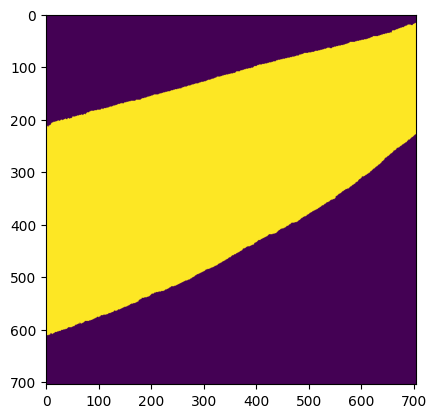

In [21]:
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]

best_mask = masks[0, :, :]

plt.imshow(best_mask)

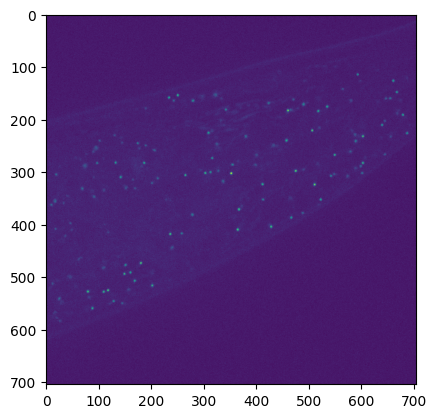

In [17]:
plt.imshow(image[:, :, 1])